# Cross-condition Patches - Vu 

- In this tutorial we aim to show how Patches can be applied to new datasets using the data originating from v3 sequencing runs contained in the [Vu (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9901190/) dataset.

- The data is a combination of aged & young cells collected at time points 0DPW (uninjured), 4DPW and 7DPW.

- Please refer to the interpretable tutorial for assessment of biological implications.

In [1]:
# Minimal imports
from ladder.data import get_data # Needed to grab data
from ladder.scripts import CrossConditionWorkflow # Our workflow object to run the cross-conditional model
import umap, torch, pyro # To set seeds + umaps
import torch.optim as opt # For defining out optimizer


# For plotting
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from umap import UMAP

# For data loading
import anndata as ad
import scanpy as sc

# Set up plots
import os
os.makedirs('plots', exist_ok=True)


klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

In [2]:
# Helpers for plotting

# Courtesy of: https://stackoverflow.com/questions/7965743/how-can-i-set-the-aspect-ratio
def force_aspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)



def grab_params(workflow, model, data="Vu"):
    ## Parameters for UMAP
    reducer_base = umap.UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)
    reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)
    
    ## All data reductions we need for the plots
    
    match model:
        case "Patches":
            base_umap = reducer_base.fit_transform(np.array(workflow.anndata.X.todense()))
            z_umap = reducer.fit_transform(workflow.anndata.obsm['patches_z_latent']) ## Z
            w_umap = reducer.fit_transform(workflow.anndata.obsm['patches_w_latent']) ## W
            rho_umap = reducer.fit_transform(workflow.anndata.obsm['patches_rho_latent']) ## rho
            
            w_pca = sc.pp.pca(workflow.anndata.obsm['patches_w_latent'], random_state=42)[:,:2] ## W PCA, grab first 2 PCs
            z_pca = sc.pp.pca(workflow.anndata.obsm['patches_z_latent'], random_state=42)[:,:2] ## Z PCA, grab first 2 PCs
    
    
            df = pd.DataFrame(base_umap)
            df.index = workflow.anndata.obs.index
            
            df.columns = ["base_1", "base_2"]
            df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
            df["w_umap_1"], df["w_umap_2"] = w_umap[:,0], w_umap[:,1]
            df["rho_umap_1"], df["rho_umap_2"] = rho_umap[:,0], rho_umap[:,1]
            df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]
            df["w_pc_1"], df["w_pc_2"] = w_pca[:,0], w_pca[:,1]
    
        case "SCANVI":
            base_umap = reducer_base.fit_transform(np.array(workflow.anndata.X.todense()))
            u_umap = reducer.fit_transform(workflow.anndata.obsm['scanvi_u_latent']) ## W
            u_pca = sc.pp.pca(workflow.anndata.obsm['scanvi_u_latent'], random_state=42)[:,:2]
            z_umap = reducer.fit_transform(workflow.anndata.obsm['scanvi_z_latent']) ## W
            z_pca = sc.pp.pca(workflow.anndata.obsm['scanvi_z_latent'], random_state=42)[:,:2]
    
            df = pd.DataFrame(base_umap)
            df.index = workflow.anndata.obs.index
            
            df.columns = ["base_1", "base_2"]
            
            df["u_umap_1"], df["u_umap_2"] = u_umap[:,0], u_umap[:,1]
            df["u_pc_1"], df["u_pc_2"] = u_pca[:,0], u_pca[:,1]
            df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
            df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]
    
    
        case "SCVI":
            base_umap = reducer_base.fit_transform(np.array(workflow.anndata.X.todense()))
            z_umap = reducer.fit_transform(workflow.anndata.obsm['scvi_latent'])
            z_pca = sc.pp.pca(workflow.anndata.obsm['scvi_latent'], random_state=42)[:,:2] 
    
            df = pd.DataFrame(base_umap)
            df.index = workflow.anndata.obs.index
            
            df.columns = ["base_1", "base_2"]
            df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
            df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]

        case "Base":
            anndata = workflow.anndata.copy()
            anndata.X = anndata.layers["normalized"]
            
            sc.pp.normalize_total(anndata, target_sum=1e4)
            sc.pp.log1p(anndata)
            sc.tl.pca(anndata, svd_solver="arpack")
            
            base_umap = reducer_base.fit_transform(np.array(anndata.X.todense()))
            base_pca = anndata.obsm['X_pca'][:,:2]

            df = pd.DataFrame(base_umap)
            df.index = anndata.obs.index

            df.columns = ["base_umap_1", "base_umap_2"]
            df["base_pc_1"], df["base_pc_2"] = base_pca[:,0], base_pca[:,1]


    
    match data:
        case "Vu":
            df["broad_type"], df["age"], df["time"], df["factorized"] = workflow.anndata.obs["broad_type"], workflow.anndata.obs["age"], workflow.anndata.obs["time"], workflow.anndata.obs["factorized"]
        case "Mascharak":
            df["broad_type"], df["treatment"], df["time"], df["factorized"] = workflow.anndata.obs["broad_type"], workflow.anndata.obs["treatment"], workflow.anndata.obs["time"], workflow.anndata.obs["factorized"]
            

    return df

## Setting up the data

In [3]:
get_data("Vu")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292M/292M [00:02<00:00, 103MB/s]

Object saved at ./data/vu_2022_ay_wh.h5ad


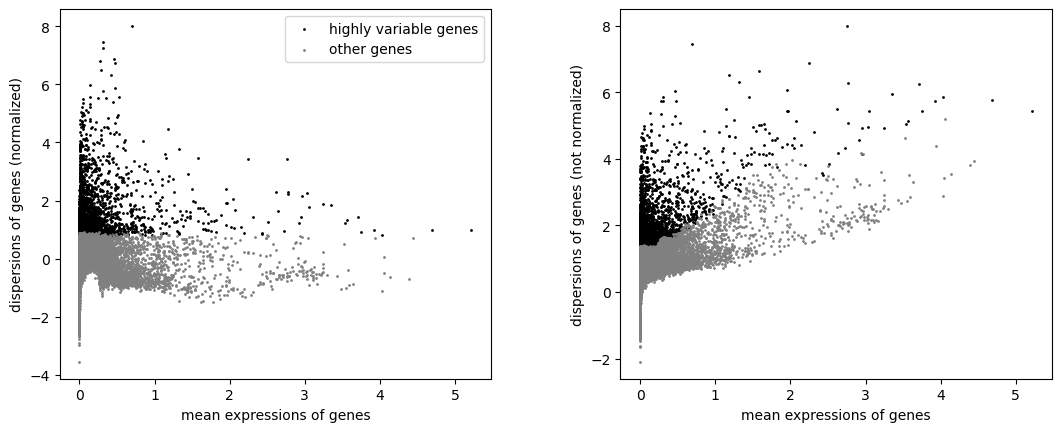

In [4]:
# Load the anndata object
anndata_vu = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")
anndata_vu.layers["normalized"] = anndata_vu.X

# Find/subset HVGs & swap to raw counts
sc.pp.highly_variable_genes(anndata_vu, n_top_genes=3000, batch_key="sample")
sc.pl.highly_variable_genes(anndata_vu)

anndata_vu = anndata_vu[:, anndata_vu.var["highly_variable"]]
anndata_vu.X = anndata_vu.layers["counts"]

In [5]:
anndata_vu

View of AnnData object with n_obs × n_vars = 26966 × 3000
    obs: 'age', 'time', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'broad_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'broad_type_colors', 'dendrogram_broad_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_gr

## Initializing and running the workflow

In [ ]:
# Initialize workflow object
workflow = CrossConditionWorkflow(anndata_vu, verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["time", "age", "broad_type"]
workflow.prep_model(factors, batch_key="sample", cell_type_label_key="broad_type", model_type='Patches')

# Train the model
if not os.path.exists('params/patches_vu_pyro.pth'):
    workflow.run_model(max_epochs=2000, convergence_threshold=1e-5, convergence_window=2000)
    workflow.save_model('params/patches_vu')

else:
    workflow.load_model('params/patches_vu')

In [7]:
results = workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.38s/it]


Calculating Profile Correlation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.32s/it]


Calculating 2-Sliced Wasserstein ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.96s/it]


Calculating Chamfer Discrepancy ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.55it/s]

Results
RMSE : 2.315 +- 0.218
Profile Correlation : 0.998 +- 0.0
2-Sliced Wasserstein : 4.626 +- 0.073
Chamfer Discrepancy : 66.818 +- 4.366


In [8]:
workflow.write_embeddings()
df_patches = grab_params(workflow, "Patches", "Vu")
df_base = grab_params(workflow, "Base", "Vu")

Written embeddings to object 'anndata.obsm' under workflow.


/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/insomnia001/depts/morpheus/users/ob2391/mi

/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Inspecting representations

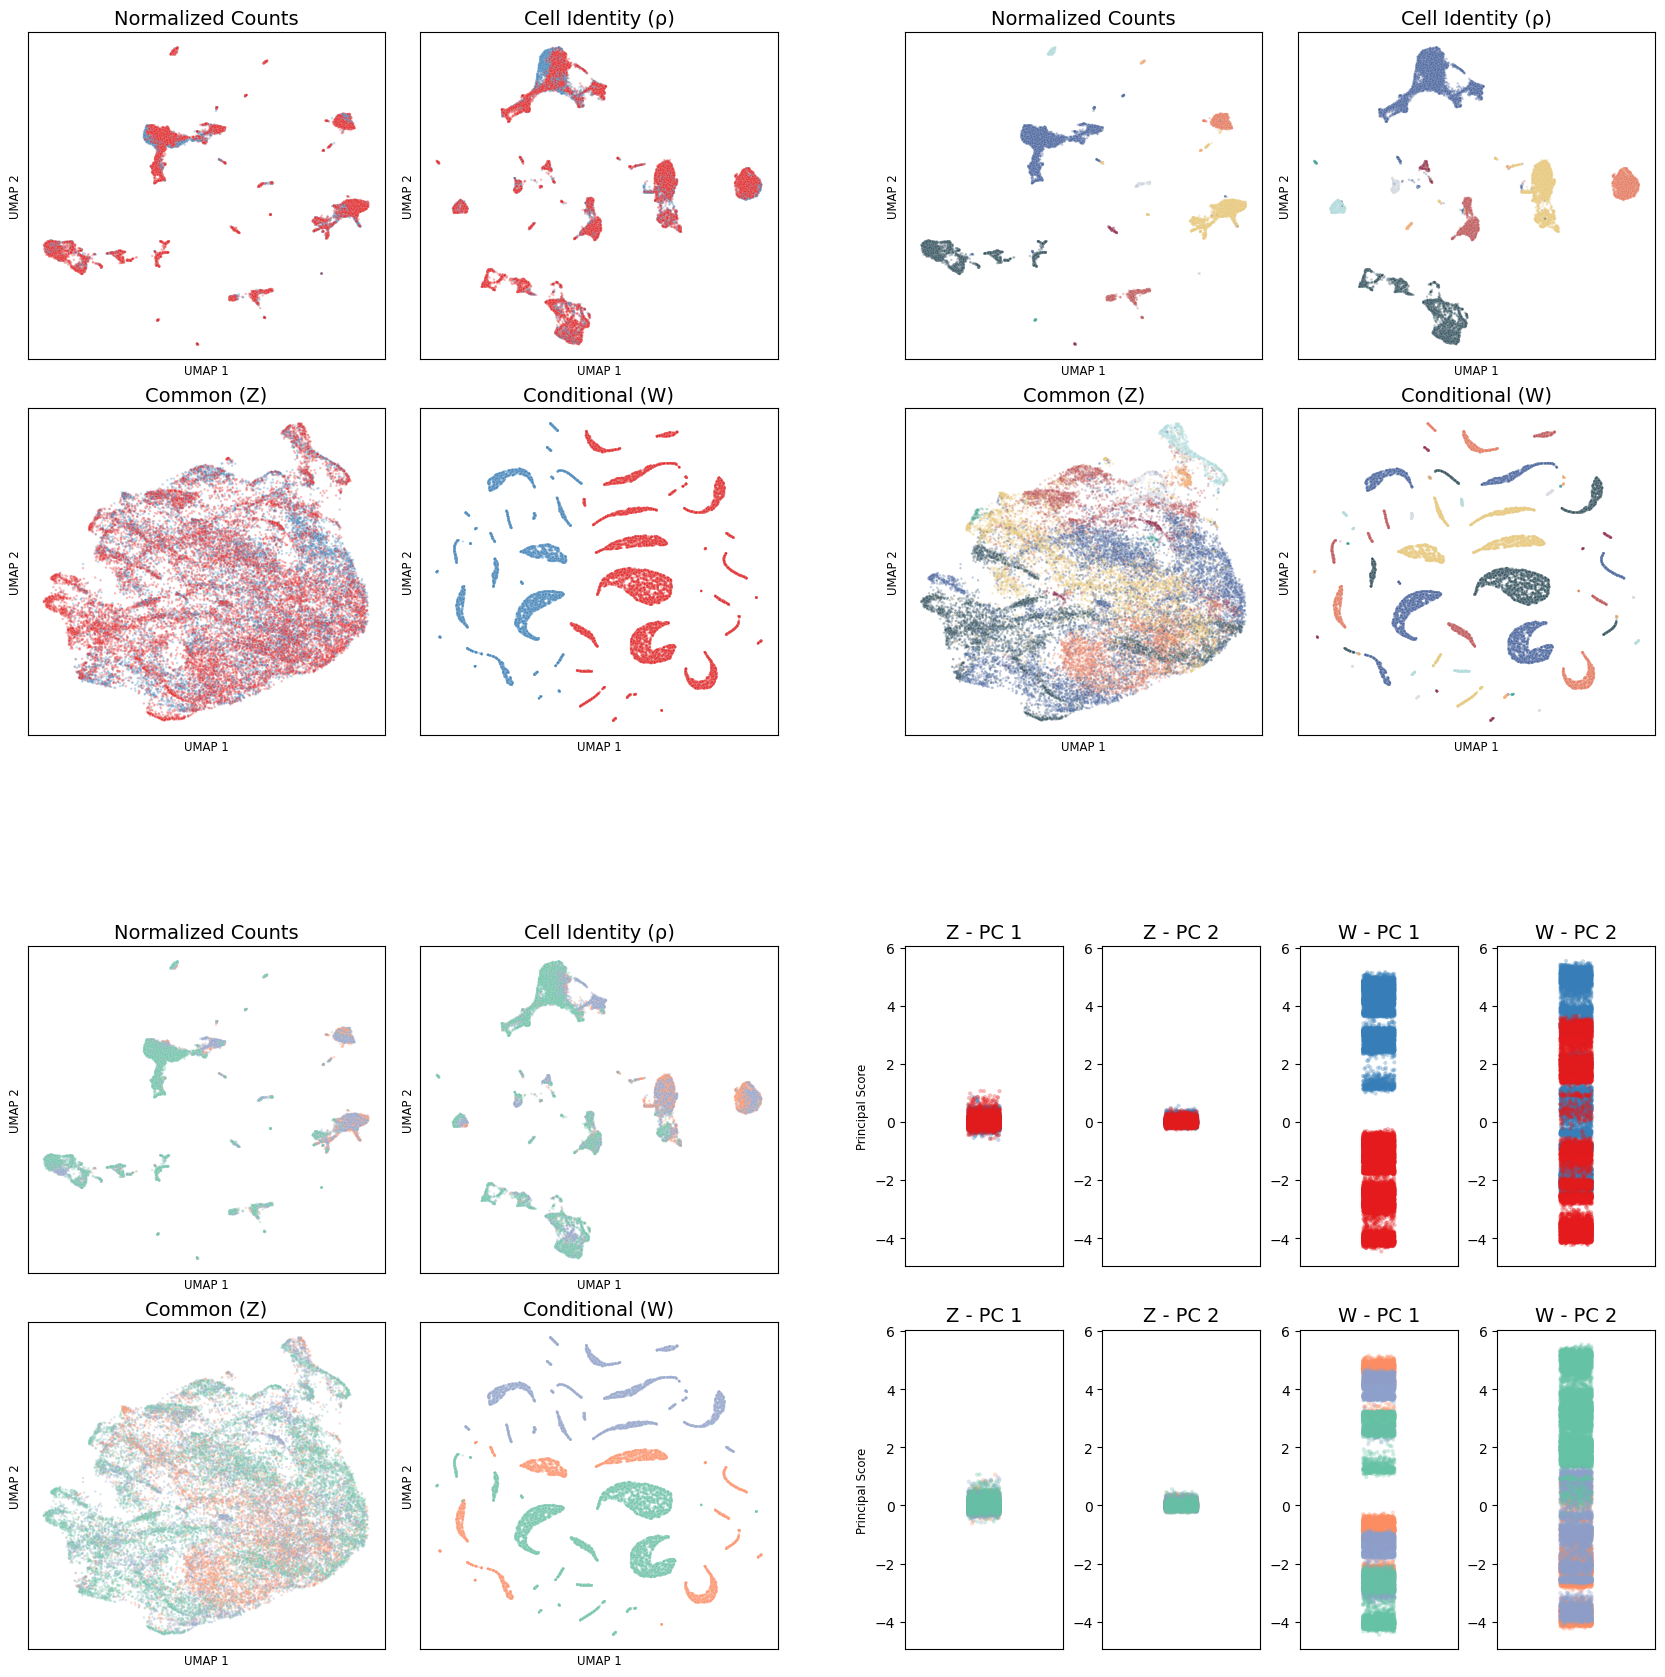

In [9]:
# Figure skeleton

fontsize=14
alpha=0.3
s=3

## Create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## Define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## Create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## Define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)
    




## Create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## Specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]

#Counts
ct = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'broad_type', palette=sns.color_palette(klee_palette), s=s, alpha=alpha)
age = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'age', palette='Set1', s=s, alpha=alpha)
time = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'time', palette='Set2', s=s, alpha=alpha)


#Identities
sns.scatterplot(df_patches, x='rho_umap_1', y='rho_umap_2', ax=ax_inner_topright[1], hue = 'broad_type', palette=sns.color_palette(klee_palette), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='rho_umap_1', y='rho_umap_2', ax=ax_inner_topleft[1], hue = 'age', palette='Set1', s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='rho_umap_1', y='rho_umap_2', ax=ax_inner_botleft[1], hue = 'time', palette='Set2', s=s, alpha=alpha, legend=False)

#Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'broad_type', palette=sns.color_palette(klee_palette), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'age', palette='Set1', s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'time', palette='Set2', s=s, alpha=alpha, legend=False)

#Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'broad_type', palette=sns.color_palette(klee_palette), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'age', palette='Set1', s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'time', palette='Set2', s=s, alpha=alpha, legend=False)




sns.stripplot(df_patches, y = "z_pc_1", hue='age', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[0], legend=False, palette='Set1')
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='age', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[1], legend=False, palette='Set1')
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='age', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[2], legend=False, palette='Set1')
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='age', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[3], legend=False, palette='Set1')
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')



sns.stripplot(df_patches, y = "z_pc_1", hue='time', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[4], legend=False, palette='Set2')
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='time', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[5], legend=False, palette='Set2')
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='time', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[6], legend=False, palette='Set2')
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='time', zorder=1, alpha=alpha, s=s, ax=ax_inner_botright[7], legend=False, palette='Set2')
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')



for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass


for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass


for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass


for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)


ct_h, ct_l = ct.get_legend_handles_labels() 
age_h, age_l = age.get_legend_handles_labels()
time_h, time_l = time.get_legend_handles_labels()

ct.legend([], frameon=False); age.legend([], frameon=False); time.legend([], frameon=False)


ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)




ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)

"""
ax_topleft = fig.add_subplot(gs_inner_topleft[:])
ax_topleft.axis('off')
ax_topleft.set_title('Cell Types', fontsize=fontsize*1.2, pad=50, weight='bold')

ax_topright = fig.add_subplot(gs_inner_topright[:])
ax_topright.axis('off')
ax_topright.set_title('Age', fontsize=fontsize*1.2, pad=50, weight='bold')

ax_botleft = fig.add_subplot(gs_inner_botleft[:])
ax_botleft.axis('off')
ax_botleft.set_title('Time Points', fontsize=fontsize*1.2, pad=50, weight='bold')


ax_botright = fig.add_subplot(gs_inner_botright[:])
ax_botright.axis('off')
ax_botright.set_title('Latent PCs', fontsize=fontsize*1.2, pad=50, weight='bold')
"""

#fig.suptitle('Vu (2022) - Patches', weight='heavy', fontsize=fontsize*1.6)



plt.savefig('plots/vu_patches_squared_full_ct.png', dpi=300, bbox_inches='tight')
plt.show()